# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [6]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [8]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [13]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [14]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e-1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [15]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

np.float64(0.16666666666666666)

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [19]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302342, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302354, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301797, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301307, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301620, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302312, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301980, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302229, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303341, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302414, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301055, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301049, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301840, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302579, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303403, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302045, Train acc

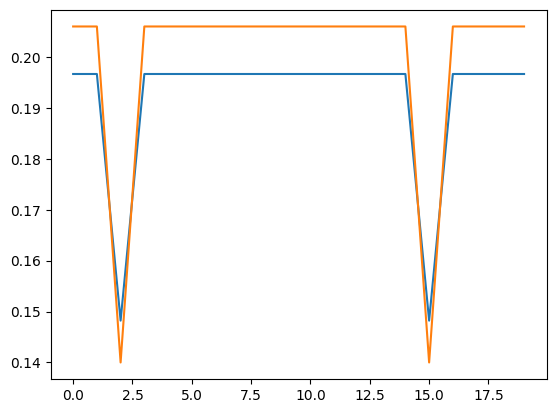

In [21]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [23]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.301600, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302920, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301643, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302416, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302808, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302545, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302576, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301650, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301992, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301690, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301795, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301620, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302401, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302000, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302178, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302074, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [27]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302756, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303038, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301894, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301875, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301484, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302012, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302237, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301525, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302084, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302568, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301443, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302102, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301922, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301824, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302041, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303105, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [30]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335657, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.304470, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.307090, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.302506, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.282610, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.281317, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.261277, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.261431, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.177811, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.918175, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.090504, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.724879, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.811462, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.195659, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.882450, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.950877, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [38]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-6)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.272162, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.148730, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.434167, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.168270, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.607305, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.067792, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.458458, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.394194, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.422199, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.488674, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.505121, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.747855, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.197853, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.032429, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.546462, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.252199, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [39]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2]
reg_strength = [1e-3, 1e-5]
hidden_layer_sizes = [64, 128, 256]
batch_size = [64, 128]
num_epochs = 16

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for lr in learning_rates:
    for rs in reg_strength:
        for ls in hidden_layer_sizes:
            for bs in batch_size:
                model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=ls, reg=rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=bs)
                temp_loss_history, temp_train_history, temp_val_history = trainer.fit()
                
                if temp_val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = temp_val_history[-1]
                    loss_history = temp_loss_history.copy()
                    train_history = temp_train_history.copy()
                    val_history = temp_val_history.copy()

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 1.939671, Train accuracy: 0.373000, val accuracy: 0.373000
Loss: 1.843149, Train accuracy: 0.525333, val accuracy: 0.538000
Loss: 1.384954, Train accuracy: 0.550111, val accuracy: 0.537000
Loss: 1.771381, Train accuracy: 0.588667, val accuracy: 0.573000
Loss: 1.716477, Train accuracy: 0.620222, val accuracy: 0.588000
Loss: 1.780083, Train accuracy: 0.605778, val accuracy: 0.577000
Loss: 1.933757, Train accuracy: 0.648333, val accuracy: 0.615000
Loss: 1.706906, Train accuracy: 0.658556, val accuracy: 0.652000
Loss: 1.618609, Train accuracy: 0.647222, val accuracy: 0.611000
Loss: 1.452437, Train accuracy: 0.646667, val accuracy: 0.601000
Loss: 1.465388, Train accuracy: 0.603667, val accuracy: 0.570000
Loss: 1.509143, Train accuracy: 0.592444, val accuracy: 0.536000
Loss: 1.544287, Train accuracy: 0.702778, val accuracy: 0.655000
Loss: 1.585565, Train accuracy: 0.639556, val accuracy: 0.601000
Loss: 1.462776, Train accuracy: 0.649556, val accuracy: 0.618000
Loss: 1.755300, Train acc

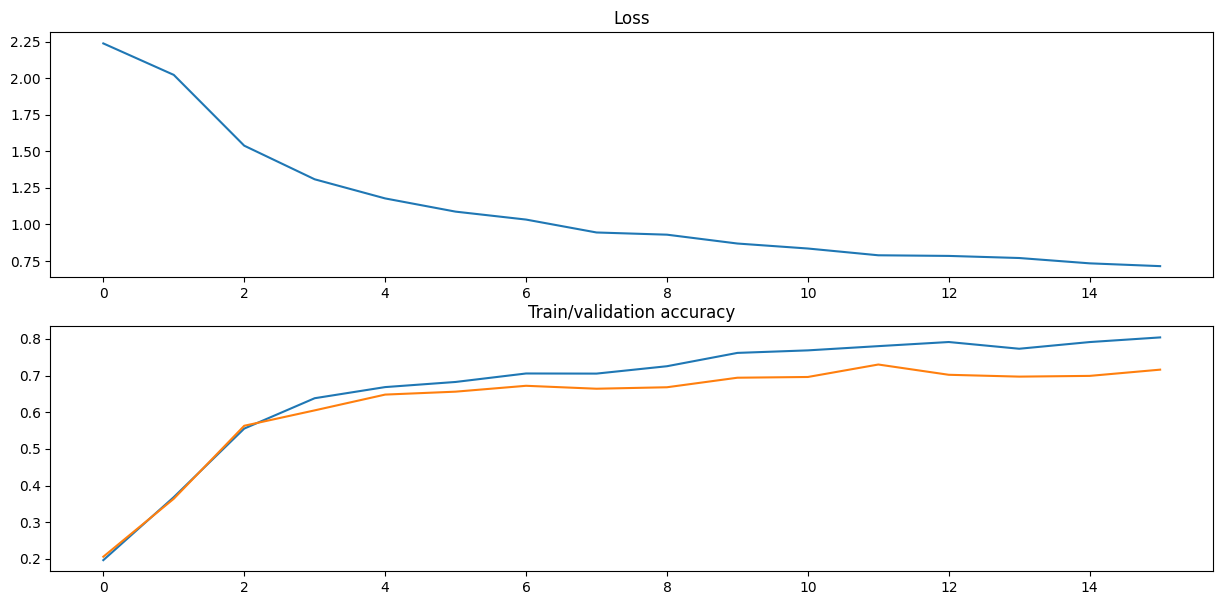

In [40]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [41]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.688000
